# DeepLabV3+ Transfer Learning Training Demo

DeepLabV3+ with interchangeable backbone transfer learning training demo
Net pretrained with COCO val2017, then fine-tuned with Yamaha-CMU Off-Road Dataset

---

Author: **Nate Haddad** nhaddad2112[at]gmail[dot]com

In [1]:
import os.path as op
import sys
import os

import torch
from torchvision import models
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
import numpy as np
from PIL import Image
import yaml

import glob
from torchvision import transforms
from torchvision.datasets.vision import VisionDataset
from typing import Any, Callable, Optional

import matplotlib.pyplot as plt
from matplotlib import gridspec
import cv2

import time
import copy
from tqdm import tqdm

from deeplab_wrapper import DeepLabWrapper

from torch.utils.data import DataLoader

sys.path.append('..')
# from utils import get_dataloader, Trainer, display_example_pair
from models import DeepLabWrapper

In [2]:
class YamahaCMUDataset(VisionDataset):
    """ A class that represents the Yamaha-CMU Off-Road dataset

    Attributes:
        root: (str)
            the root directory
        transforms: (Optional[Callable])
            torch transforms to use

    Methods:
        __len__():
            returns the length of the dataset
        __getitem__(index):
            returns the item at the given index of this dataset
    """

    def __init__(self, root: str, resize_shape: tuple,
                 transforms: Optional[Callable] = None) -> None:
        """ Initializes a YamahaCMUDataset object

        Args:
            root: (str)
                the root directory
            transforms: (Optional[Callable])
                torch transforms to use
        """
        super().__init__(root, transforms)
        image_paths = []
        mask_paths = []
        image_mask_pairs = glob.glob(root + '/*/')
        for image_mask in image_mask_pairs:
            image_paths.append(glob.glob(image_mask + '*.jpg')[0])
            mask_paths.append(glob.glob(image_mask + '*.png')[0])
        self.image_names = image_paths
        self.mask_names = mask_paths

        if resize_shape:
            self.image_height, self.image_width = resize_shape
            self.resize = True
        else:
            self.image_height, self.image_width = (544, 1024)
            self.resize = False

    def __len__(self) -> int:
        """ Returns the length of the dataset """
        return len(self.image_names)

    def __getitem__(self, index: int) -> Any:
        """ Returns the item at the given index of this dataset

        Args:
            index: (int)
                the index of the item to get

        Returns:
            the sample at the given index
        """

        image_path = self.image_names[index]
        mask_path = self.mask_names[index]
        image = Image.open(image_path)
        image = image.convert("RGB")
        mask = Image.open(mask_path)
        mask = np.array(mask)
        class_colors = np.unique(mask)
        print(class_colors)
        if self.resize:
            mask = cv2.resize(mask,
                              dsize=(self.image_width, self.image_height),
                              interpolation=cv2.INTER_CUBIC)
        # remove void class (atv)
        if 0 in class_colors:
            class_colors = class_colors[1:]
        label_masks = mask == class_colors[:, None, None]
        masks = np.zeros((20, self.image_height, self.image_width))
        for index, class_color in enumerate(class_colors):
            masks[class_color - 1] = label_masks[index, :, :] * 255
        sample = {"image": image, "mask": masks}
        if self.transforms:
            sample["image"] = self.transforms(sample["image"])
            sample['mask'] = torch.as_tensor(sample['mask'], dtype=torch.uint8)
        return sample


def get_dataloader(data_dir: str, batch_size: int=2, resize_shape: tuple=None) -> torch.utils.data.DataLoader:
    """ Creates a dataloader for the given dataset

    Args:
        data_dir: (str)
            the directory of the dataset
        batch_size: (int=2)
            the batch size to use

    Returns:
        torch.utils.data.DataLoader
    """

    if resize_shape:
        preprocess = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(resize_shape),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    else:
        preprocess = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    image_datasets = {
        x: YamahaCMUDataset(data_dir + x, resize_shape, transforms=preprocess) for x in ['train', 'valid']
    }

    dataloaders = {
        x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, drop_last=True)
        for x in ['train', 'valid']
    }
    return dataloaders


In [3]:
def mean_iou(outputs: torch.Tensor, labels: torch.Tensor) -> float:
    """ Calculates the mean IoU (Jaccard index) between
        two tensors. Shape expected to be same.

    Args:
        outputs: (torch.Tensor)
            the output of a model
        labels: (torch.Tensor)
            the ground truth labels

    Returns:
        float
    """
    #outputs = torch.from_numpy(outputs)
    #labels = torch.from_numpy(labels)
    intersection = torch.logical_and(labels, outputs)
    union = torch.logical_or(labels, outputs)
    iou_score = torch.sum(intersection) / torch.sum(union)
    return iou_score.mean()


def imshow(image: Image) -> None:
    """ Displays an image

    Args:
        image: (Image) the input image to display

    Returns:
        None
    """
    np_image = image.numpy()
    plt.imshow(np.transpose(np_image, (1, 2, 0)))


def label_to_color_image(label: np.ndarray) -> np.ndarray:
    """ Adds color defined by the dataset colormap to the label.
        From https://github.com/tensorflow/models/tree/master/research/deeplab

    Args:
        label: (np.ndarray)
            A 2D array with integer type, storing the segmentation label.

    Returns:
        A 2D array with floating type. The element of the array
        is the color indexed by the corresponding element in the input label
        to the CMU Yamaha dataset color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
            map maximum entry.
    """
    if len(label.shape) != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_cmu_yamaha_offroad_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]


def create_cmu_yamaha_offroad_label_colormap() -> np.ndarray:
    """ Creates a label colormap used in CMU Yamaha Offroad
        dataset segmentation dataset.

    Returns:
        A Colormap for visualizing segmentation results.
    """
    colormap = np.zeros((256, 3), dtype=int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3

    return colormap


def vis_segmentation(image: np.ndarray, seg_map: np.ndarray) -> None:
    """ Visualizes input image, segmentation map and overlay view
        From https://github.com/tensorflow/models/tree/master/research/deeplab

    Args:
        image: (np.ndarray)
            the rgb image
        seg_map: (np.ndarray)
            the mask to overlay

    Returns:
        None
    """
    label_names = np.asarray([
        'non-traversable', 'rough trail', 'smooth trail', 'traversable grass',
        'low vegetation', 'obstacle', 'high vegetation', 'sky'
    ])

    full_label_map = np.arange(len(label_names)).reshape(len(label_names), 1)
    full_color_map = label_to_color_image(full_label_map)

    plt.figure(figsize=(15, 5))
    grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')

    plt.subplot(grid_spec[1])
    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    plt.imshow(seg_image)
    plt.axis('off')
    plt.title('segmentation map')

    plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.5)
    plt.axis('off')
    plt.title('segmentation overlay')

    unique_labels = np.unique(seg_map)
    ax = plt.subplot(grid_spec[3])
    plt.imshow(full_color_map[unique_labels].astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), label_names[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0.0)
    plt.grid('off')
    plt.show()


def draw_segmentation(image: np.ndarray, seg_map: np.ndarray) -> np.ndarray:
    """ Visualizes input image overlayed with segmentation map

    Args:
        image: (np.ndarray)
            the rgb image
        seg_map: (np.ndarray)
            the mask to overlay

    Returns:
        overlay: (np.ndarray)
            input image overlayed with segmentation map
    """
    label_names = np.asarray([
        'non-traversable', 'rough trail', 'smooth trail', 'traversable grass',
        'low vegetation', 'obstacle', 'high vegetation', 'sky'
    ])

    full_label_map = np.arange(len(label_names)).reshape(len(label_names), 1)
    full_color_map = label_to_color_image(full_label_map)
    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    overlay = cv2.addWeighted(image, 0.5, seg_image, 0.5, 0)
    return overlay



    # """ Visualizes input image and segmentation map. Used for visualizations.

    # Args:
    #     image: (np.ndarray) the rgb image
    #     mask: (np.ndarray) the mask of the input image

    # Returns:
    #     None
    # """
    # _, ax = plt.subplots(1, 2, figsize=(15, 15))
    # ax[0].imshow(image)
    # ax[0].axis('off')
    # ax[0].set_title('Original Image')
    # ax[1].imshow(mask)
    # ax[1].axis('off')
    # ax[1].set_title('Mask')


def vis_grid_4x3(model, data_path: str) -> None:
    """ Visualizes a grid of original, mask, and predicted mask images.
        Used to visualize the results of multiple images after running
        inference.

    Args:
        model: (torchvision.models)
            the model to use to run inference

    Returns:
        None
    """
    images = []
    pair_directories = [op.join(data_path, 'train/iid000183'),
                        op.join(data_path, 'train/iid000657'),
                        op.join(data_path, 'train/iid000499'),
                        op.join(data_path, 'train/iid001092')]
    brown = [139, 69, 19]
    dark_green = [0, 100, 0]
    forest_green = [34, 139, 34]
    sky = [0, 0, 255]
    gray = [211, 211, 211]
    red = [255, 0, 0]
    green = [0, 255, 0]
    white = [255, 255, 255]
    colors = torch.as_tensor([white, green, brown, gray, forest_green, red,
                              dark_green, sky])
    colors = (colors).numpy().astype("uint8")
    for i in range(4):
        image_mask_pair = glob.glob(pair_directories[i] + '/*')
        path1, path2 = image_mask_pair
        mask = Image.open(path1)
        mask = np.array(mask.convert('RGB'))
        image = Image.open(path2)
        seg_map = run_inference(model, image)
        seg_map.putpalette(colors)
        seg_map = seg_map.convert('RGB')
        seg_map = np.array(seg_map)
        images = images + [image, mask, seg_map]
    plt.figure(figsize=(10, 10))
    col = ['Original', 'Mask', 'Ours']
    for i in range(len(images)):
        ax = plt.subplot(4, 3, i+1)
        if i < 3:
            ax.set_title(col[i])
        plt.imshow(images[i])
        plt.axis("off")
    plt.subplots_adjust(wspace=.01, hspace=-0.6)
    plt.savefig('sample.png', bbox_inches=0, transparent="True",
                pad_inches=0)

def display_example_pair(image: np.ndarray, mask: np.ndarray) -> None:
    """ Visualizes input image and segmentation map. Used for visualizations.

    Args:
        image: (np.ndarray) the rgb image
        mask: (np.ndarray) the mask of the input image

    Returns:
        None
    """
    _, ax = plt.subplots(1, 2, figsize=(15, 15))
    ax[0].imshow(image)
    ax[0].axis('off')
    ax[0].set_title('Original Image')
    ax[1].imshow(mask)
    ax[1].axis('off')
    ax[1].set_title('Mask')

def run_inference(model, image):
    """ Runs inference on a single image with the given model

    Args:
        model: (torchvision.models)
            the model to use
        image: (np.ndarray)
            the image to use

    Returns:
        (Image) the segmentation map predicted by the model
    """
    # apply the same transforms that were applied to input images when training the model
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(image)
    # put the image in a batch (as expected by the model)
    input_batch = input_tensor.unsqueeze(0)
    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')
    with torch.no_grad():
        output = model(input_batch)['out'][0]
    output_predictions = output.argmax(0)
    if isinstance(image, np.ndarray):
        return Image.fromarray(output_predictions.byte().cpu().numpy()).resize((image.shape[1], image.shape[0]))
    return Image.fromarray(output_predictions.byte().cpu().numpy()).resize(image.size)


def save_video(frames: list, outfile_path: str) -> None:
    """ Saves a list of frames to a video file.

    Args:
        frames: list
            List of frames to process into a video
        outfile_path: str
            Path to write the video to
    """
    h, w, *_ = frames[0].shape
    outfile = cv2.VideoWriter(outfile_path, -1, 30, (w, h))
    for frame in frames:
        outfile.write(frame)
    outfile.release()

In [4]:
class Trainer:
    """ This class trains DeepLab models given a configuration of hyperparameters 

    Attributes:
        deeplab: DeepLabWrapper
            Model to train
        dataloaders: torch.utils.data.DataLoader
            Dataloaders to use for training
        criterian: torch.nn.CrossEntropyLoss
            Loss function to use
        optimizer: torch.optim.Adam
            Optimizer to use
        num_epochs: int
            Number of epochs to train
        is_inception: bool
            Use auxiliary outputs and loss during training
        """

    def __init__(self, deeplab: DeepLabWrapper, dataloaders: torch.utils.data.DataLoader,
                 criterion: torch.nn.CrossEntropyLoss, optimizer: torch.optim.Adam, num_epochs: int = 25,
                 is_inception: bool = False):
        """ Initialization method for Trainer base class

        Args:
            model: (torchvision.models.segmentation.deeplabv3)
                the model used in training
            dataloaders: (torch.utils.data.DataLoader)
                the dataloader to use
            criterion: (torch.nn.CrossEntropyLoss)
                the loss function to use
            optimizer: (torch.optim.Adam)
                the optimizer to use
            num_epochs: (int=25)
                the number of epochs to train
            is_inception: (bool)
                whether or not to use auxiliary outputs in training
        """
        self.deeplab = deeplab
        self.dataloaders = dataloaders
        self.criterion = criterion
        self.optimizer = optimizer
        self.num_epochs = num_epochs
        self.is_inception = is_inception

    def train(self) -> None:
        """ This function is used to train a model

        Returns:
            model, val_mean_iou_history
        """
        torch.cuda.empty_cache()
        self.deeplab.model.train()
        since = time.time()
        device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
        val_mean_iou_history = []
        best_model_wts = copy.deepcopy(self.deeplab.model.state_dict())
        best_mean_iou = 0.0
        self.deeplab.model.to(device)
        for epoch in range(self.num_epochs):
            print(f'Epoch {epoch + 1}/{self.num_epochs}')
            print('-' * 10)

            for phase in ['train', 'valid']:
                if phase == 'train':
                    self.deeplab.model.train()
                else:
                    self.deeplab.model.eval()

                running_loss = 0.0
                running_mean_iou = 0

                # Iterate over data.
                for sample in tqdm(iter(self.dataloaders[phase])):

                    inputs = sample['image'].to(device)
                    labels = sample['mask'].to(device)

                    print("in:", inputs)
                    print("lanels:", labels)

                    label = torch.argmax(labels, dim=1)
                    print("labels argmax:", label)

                    self.optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        # Get model outputs and calculate loss
                        if self.is_inception and phase == 'train':
                            outputs = self.deeplab.model(inputs)
                            loss1 = self.criterion(outputs['out'], label)
                            loss2 = self.criterion(outputs['aux'], label)
                            loss = loss1 + 0.4 * loss2
                        else:
                            outputs = self.deeplab.model(inputs)
                            outputs['out'] = outputs['out'].to(device)
                            loss = self.criterion(outputs['out'], label)
                        _, preds = torch.max(outputs['out'], 1)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            self.optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_mean_iou += mean_iou(torch.argmax(outputs['out'], 1), label).item()

                epoch_loss = running_loss / len(self.dataloaders[phase].dataset)
                epoch_mean_iou = running_mean_iou / len(self.dataloaders[phase])
                print('{} Loss: {:.4f} mIoU: {:.4f}'.format(phase, epoch_loss, epoch_mean_iou))
                # deep copy the model
                if phase == 'valid' and epoch_mean_iou > best_mean_iou:
                    best_mean_iou = epoch_mean_iou
                    best_model_wts = copy.deepcopy(self.deeplab.model.state_dict())
                if phase == 'valid':
                    val_mean_iou_history.append(epoch_mean_iou)

            print()

        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best val mean IoU: {:4f}'.format(best_mean_iou))

        # load best model weights
        self.deeplab.model.load_state_dict(best_model_wts)
        return self.deeplab, val_mean_iou_history


In [5]:
torch.cuda.is_available()
torch.cuda.device_count()
torch.cuda.empty_cache()

In [6]:
np.random.seed(42)

Set up all of our path variables and hyperparamters needed to train the model. Adjust accordingly to your needs

In [7]:
with open('/home/nb1/spilkova/data/semantic-segmentation/config/training_conf_rellis/conf_rellis_mnv3_10.yaml', 'r') as f:
    config = yaml.safe_load(f)

Set up the `data` and `model` directories

In [8]:
os.makedirs('../data', exist_ok=True)
os.makedirs('../runs', exist_ok=True)

Load an example image from the training set

[  0  34  66  99 102 127 134 153 204 239 255]
[[[  0]]

 [[ 34]]

 [[ 66]]

 [[ 99]]

 [[102]]

 [[127]]

 [[134]]

 [[153]]

 [[204]]

 [[239]]

 [[255]]]


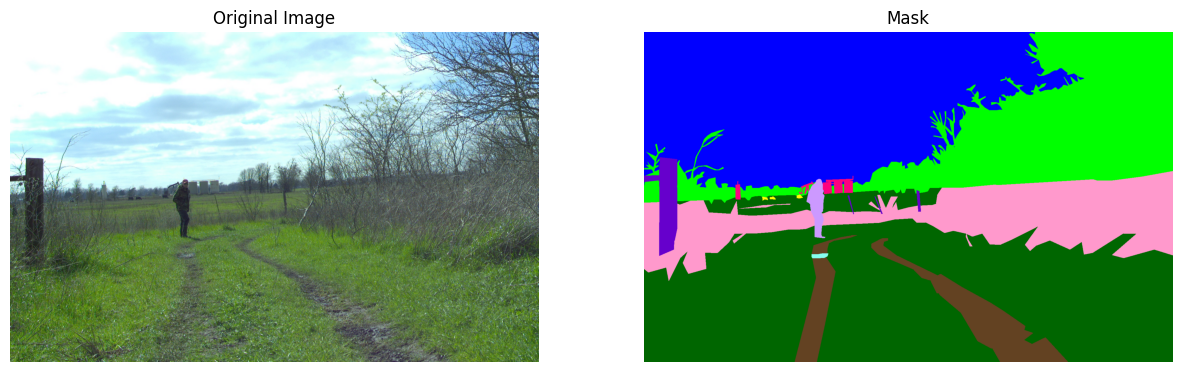

In [9]:
example_image = Image.open(op.join('..', config['DATA_PATH'], 'train/iid00008/rgb.jpg'))
example_mask = Image.open(op.join('..', config['DATA_PATH'], 'train/iid00008/labels.png'))
image_display = np.array(example_image)
mask_display = np.array(example_mask.convert('RGB'))
display_example_pair(image_display, mask_display)

mask = Image.open(op.join('..', config['DATA_PATH'], 'train/iid00008/labels.png'))
mask = np.array(mask)
class_colors = np.unique(mask)
print(class_colors)
print(class_colors[:, None, None])


# indices = np.zeros(mask.shape[:2], dtype=np.uint8)
# for i, color in enumerate(class_colors):
#     indices[(mask == color).all(axis=-1)] = i

# # Create binary masks for each class
# masks = np.zeros((len(class_colors), mask.shape[0], mask.shape[1]), dtype=np.uint8)
# for i in range(len(class_colors)):
#     masks[i] = (indices == i).astype(np.uint8)
# print(masks)

Load data into dataloaders

In [10]:
dataloaders = get_dataloader(config['DATA_PATH'],
                             batch_size=config['BATCH_SIZE'],
                             resize_shape=(config['IMG_HEIGHT'],
                             config['IMG_WIDTH']))

### Model Selection

Create the model. Note that the model is pretrained on COCO val2017. Replace the output layer with 8 mask channels and the correct number of nodes for the last layer

In [11]:
model = DeepLabWrapper(backbone=config['BACKBONE'],
                       num_mask_channels=config['NUM_MASK_CHANNELS'],
                       pretrained=True,
                       progress=True,
                       aux_loss=True)

/home/nb1/spilkova/data/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nb1/spilkova/data/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Select the optimizer and loss function

In [12]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters, lr=float(config['LEARNING_RATE']))

Train the model

In [13]:
trainer = Trainer(model, dataloaders, criterion, optimizer, num_epochs=config['NUM_EPOCHS'], is_inception=config['IS_INCEPTION']);
print(trainer.dataloaders['train'].dataset)
config['DATA_PATH']

Dataset YamahaCMUDataset
    Number of datapoints: 3302
    Root location: /home/nb1/spilkova/data/Rellis3D/train
    Compose(
    ToTensor()
    Resize(size=(544, 1024), interpolation=bilinear, max_size=None, antialias=True)
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


'/home/nb1/spilkova/data/Rellis3D/'

In [14]:
trainer.train()

RuntimeError: CUDA error: invalid device ordinal
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


---
Save the entire model

In [ ]:
model.save_model(config['SAVE_MODEL_PATH'])